In [86]:
#!pip install numpy pandas tqdm matplotlib sentence-transformers scikit-learn tensorflow

In [87]:
import sqlite3
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MeanAbsoluteError


In [88]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [89]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [90]:
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5080 entries, 31 to 7581
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5080 non-null   int64 
 1   keyword   5080 non-null   object
 2   location  5080 non-null   object
 3   text      5080 non-null   object
 4   target    5080 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 238.1+ KB


fine_tuned_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim=512)

text_embeddings = []
for text in tqdm(df_train['text'].tolist(), total=len(df_train)):
    text_embeddings.append(fine_tuned_model.encode(text, convert_to_tensor=False))


df_train['text_embeddings'] = text_embeddings
print(df_train.info())

# Connect to the SQLite database
conn = sqlite3.connect('df_train_mxbai.db')
cursor = conn.cursor()

# Create the table with the specified columns
cursor.execute('''
    CREATE TABLE IF NOT EXISTS embeddings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        keyword TEXT,
        location TEXT,
        text TEXT,
        target INTEGER,
        text_embeddings BLOB
    )
''')

conn.commit()

# Insert data into the table
for idx, (keyword, location, text, target, text_emb) in enumerate(zip(df_train['keyword'], df_train['location'], df_train['text'], df_train['target'], text_embeddings)):
    text_emb_np = text_emb
    cursor.execute('''
        INSERT INTO embeddings (keyword, location, text, target, text_embeddings)
        VALUES (?, ?, ?, ?, ?)
    ''', (keyword, location, text, target, text_emb_np.tobytes()))

conn.commit()
conn.close()

In [91]:
# Load the embeddings from the vector database
def load_embeddings(db_path):
    conn = sqlite3.connect(db_path)
    
    query = 'SELECT * FROM embeddings'
    result = conn.execute(query).fetchall()
    
    columns = ['id', 'keyword', 'location', 'text', 'target', 'text_embeddings']
    df = pd.DataFrame(result, columns=columns)
    
    df['text_embeddings'] = df['text_embeddings'].apply(lambda x: np.frombuffer(x, dtype=np.float32))
    
    conn.close()
    
    return df

# Usage
db_path = 'df_train_mxbai.db'
training_df = load_embeddings(db_path)
training_df.head()

,id,keyword,location,text,target,text_embeddings
0,1,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,"[-0.2297588, -0.15362741, 0.20142506, 1.212245..."
1,2,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,"[-0.12027328, 0.1756676, -0.02533234, 0.825559..."
2,3,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,"[0.3046259, -0.4213943, -0.41937813, 0.7259215..."
3,4,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,"[0.87511456, -0.35229594, -0.3072627, 0.668876..."
4,5,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,"[0.006783782, 0.34091398, -0.04495456, 0.22801..."


In [94]:
# Step 2: Load Data from training_df
text_embeddings = np.array(training_df['text_embeddings'].tolist())
targets = np.array(training_df['target'].tolist())

# Step 3: Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(text_embeddings, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = Sequential([
    Dense(528, input_dim=text_embeddings.shape[1]),
    ReLU(),
    Dense(256),
    ReLU(),
    Dense(128),
    ReLU(),
    Dense(64),
    ReLU(),
    Dense(32),
    ReLU(),
    Dense(1)
])

# Step 5: Compile the Model
#optimizer = RMSprop(learning_rate=0.01)
#optimizer = Adam(learning_rate=0.0001)
optimizer = SGD(learning_rate=0.01)
#optimizer = Adagrad(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=MeanAbsoluteError(),  
              metrics=[BinaryAccuracy()])
# Step 6: Train the Model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))


# Step 7: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6321 - loss: 0.3936 - val_binary_accuracy: 0.7657 - val_loss: 0.2903
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7938 - loss: 0.2724 - val_binary_accuracy: 0.8031 - val_loss: 0.2665
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8193 - loss: 0.2361 - val_binary_accuracy: 0.8051 - val_loss: 0.2512
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8348 - loss: 0.2249 - val_binary_accuracy: 0.8130 - val_loss: 0.2430
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8306 - loss: 0.2148 - val_binary_accuracy: 0.8091 - val_loss: 0.2375
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8469 - loss: 0.2052 - val_binary_accuracy: 0.8150 - val_loss: 0.2359
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8513 - loss: 0.1981 - val_binary_accuracy: 0.8189 - val_loss: 0.2287
Epoch 

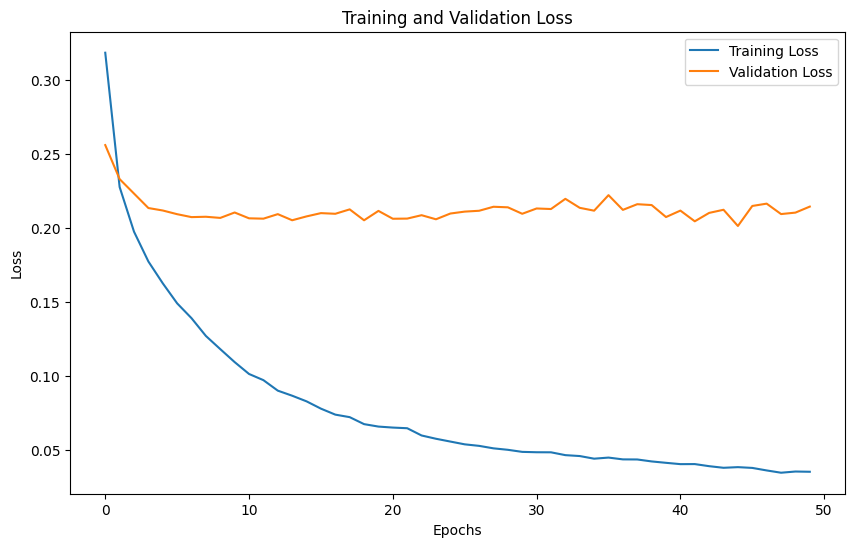

In [ ]:
# Step 8: Plot the Losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

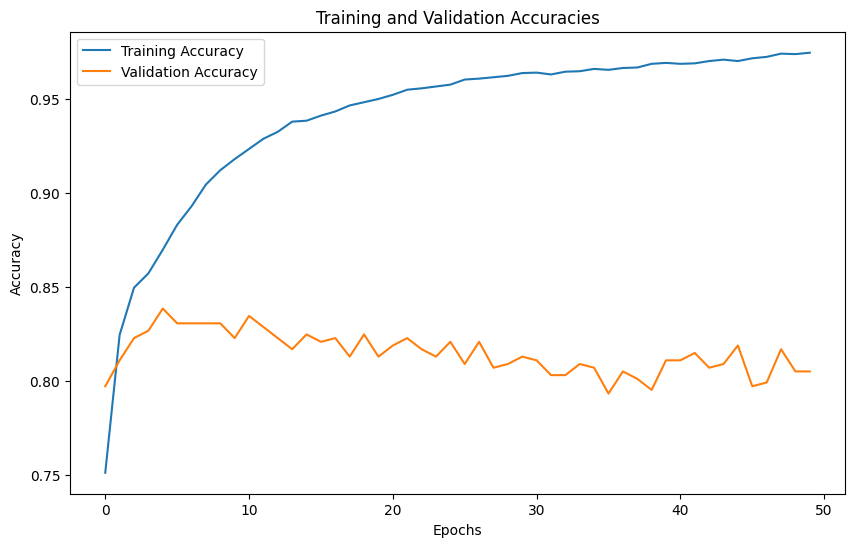

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()